In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
import warnings
warnings.filterwarnings("ignore")

In [42]:
data = pd.read_csv('temperature.csv')

In [43]:
data

,Unnamed: 0,Datetime,Hourly_Temp
0,0,04-01-2022 00:00,20.867
1,1,04-01-2022 01:00,21.000
2,2,04-01-2022 02:00,20.867
3,3,04-01-2022 03:00,20.650
4,4,04-01-2022 04:00,20.400
...,...,...,...
7051,7051,24-10-2022 19:00,25.567
7052,7052,24-10-2022 20:00,25.183
7053,7053,24-10-2022 21:00,24.600
7054,7054,24-10-2022 22:00,23.986


#### Data Preprocessing


In [44]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7056 entries, 0 to 7055
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Unnamed: 0   7056 non-null   int64  
 1   Datetime     7056 non-null   object 
 2   Hourly_Temp  7056 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 165.5+ KB


In [45]:
summed_data = {
    'Datetime': data['Datetime'][::2].reset_index(drop=True),  
    'Hourly_Temp': (data['Hourly_Temp'][::2].values + data['Hourly_Temp'][1::2].values) 
}

data = pd.DataFrame(summed_data)

In [46]:
# df = pd.DataFrame(data)
# df['Datetime'] = pd.to_datetime(df['Datetime'], format='%d-%m-%Y %H:%M')
data['Datetime'] = pd.to_datetime(data['Datetime'], format='%d-%m-%Y %H:%M')
data.set_index('Datetime', inplace=True)

In [47]:
data

,Hourly_Temp
Datetime,
2022-01-04 00:00:00,41.867
2022-01-04 02:00:00,41.517
2022-01-04 04:00:00,40.500
2022-01-04 06:00:00,39.300
2022-01-04 08:00:00,38.900
...,...
2022-10-24 14:00:00,51.669
2022-10-24 16:00:00,53.233
2022-10-24 18:00:00,51.727


In [48]:
# Fit the SARIMAX model
model = SARIMAX(data['Hourly_Temp'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
results = model.fit()

print(results.summary())


                                     SARIMAX Results                                      
Dep. Variable:                        Hourly_Temp   No. Observations:                 3528
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood              -11713.704
Date:                            Wed, 25 Sep 2024   AIC                          23437.409
Time:                                    17:43:45   BIC                          23468.233
Sample:                                01-04-2022   HQIC                         23448.407
                                     - 10-24-2022                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5439      0.064     -8.476      0.000      -0.670      -0.418
ma.L1          0.6699      0.058   

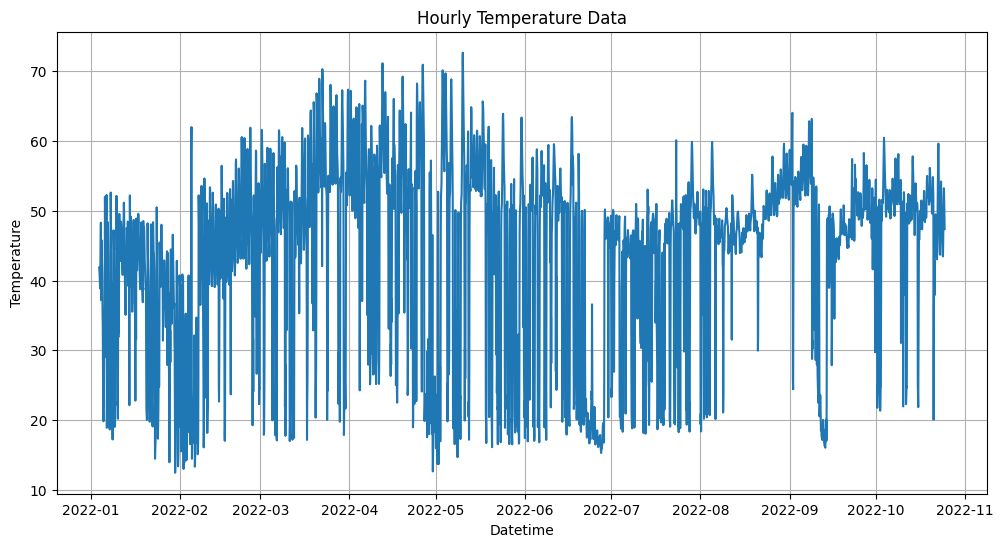

In [49]:
# Plot the data
plt.figure(figsize=(12, 6))
plt.plot(data['Hourly_Temp'])
plt.title('Hourly Temperature Data')
plt.xlabel('Datetime')
plt.ylabel('Temperature')
plt.grid(True)
plt.show()


# Test Stationarity


In [50]:
def test_stationarity(timeseries):
    # Dickey-Fuller test
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value

    return dfoutput

result = test_stationarity(data['Hourly_Temp'])
print("Augmented Dickey-Fuller Test:")
print(result)

Augmented Dickey-Fuller Test:
Test Statistic                -6.362128e+00
p-value                        2.459734e-08
#Lags Used                     2.700000e+01
Number of Observations Used    3.500000e+03
Critical Value (1%)           -3.432220e+00
Critical Value (5%)           -2.862366e+00
Critical Value (10%)          -2.567210e+00
dtype: float64


### Perform Differencing


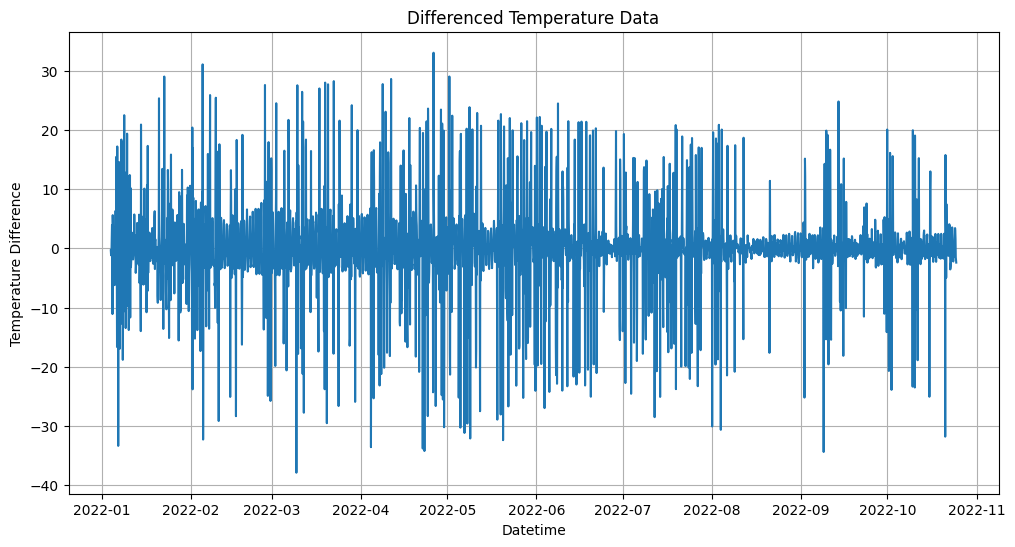

In [51]:
# Differencing to make the series stationary
data['Temp_Diff'] = data['Hourly_Temp'] - data['Hourly_Temp'].shift(1)
data.dropna(inplace=True)

# Plot differenced data
plt.figure(figsize=(12, 6))
plt.plot(data['Temp_Diff'])
plt.title('Differenced Temperature Data')
plt.xlabel('Datetime')
plt.ylabel('Temperature Difference')
plt.grid(True)
plt.show()

In [52]:
data['Temp_Diff'].value_counts().unique

<bound method Series.unique of Temp_Diff
-1.000     8
 0.000     8
 0.100     7
-0.167     7
-0.900     7
          ..
 2.533     1
 3.067     1
 6.333     1
 0.367     1
 15.167    1
Name: count, Length: 2775, dtype: int64>

In [53]:
result = test_stationarity(data['Temp_Diff'])
print("Augmented Dickey-Fuller Test on Differenced Data:")
print(result)

Augmented Dickey-Fuller Test on Differenced Data:
Test Statistic                -1.668170e+01
p-value                        1.514459e-29
#Lags Used                     2.700000e+01
Number of Observations Used    3.499000e+03
Critical Value (1%)           -3.432220e+00
Critical Value (5%)           -2.862366e+00
Critical Value (10%)          -2.567210e+00
dtype: float64


## Fit SARIMAX Model


In [54]:
# model = SARIMAX(data['Hourly_Temp'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 24))
# results = model.fit(disp=True)

In [55]:
forecast_steps = 24 
forecast = results.get_forecast(steps=forecast_steps)

In [56]:
forecast

In [75]:
# date_range = pd.date_range(start=data.index[-1], periods=forecast_steps + 1, freq='H')
date_range = pd.date_range(start=data.index[-1] + pd.Timedelta(hours=1), periods=forecast_steps + 1, freq='H')
date_range

DatetimeIndex(['2022-10-24 23:00:00', '2022-10-25 00:00:00',
               '2022-10-25 01:00:00', '2022-10-25 02:00:00',
               '2022-10-25 03:00:00', '2022-10-25 04:00:00',
               '2022-10-25 05:00:00', '2022-10-25 06:00:00',
               '2022-10-25 07:00:00', '2022-10-25 08:00:00',
               '2022-10-25 09:00:00', '2022-10-25 10:00:00',
               '2022-10-25 11:00:00', '2022-10-25 12:00:00',
               '2022-10-25 13:00:00', '2022-10-25 14:00:00',
               '2022-10-25 15:00:00', '2022-10-25 16:00:00',
               '2022-10-25 17:00:00', '2022-10-25 18:00:00',
               '2022-10-25 19:00:00', '2022-10-25 20:00:00',
               '2022-10-25 21:00:00', '2022-10-25 22:00:00',
               '2022-10-25 23:00:00'],
              dtype='datetime64[ns]', freq='h')

In [69]:
forecast_values = forecast.predicted_mean
forecast_conf_int = forecast.conf_int()

In [70]:
forecast_conf_int.head()

,lower Hourly_Temp,upper Hourly_Temp
2022-10-25 00:00:00,33.424474,59.914824
2022-10-25 02:00:00,23.195974,63.088811
2022-10-25 04:00:00,19.812883,68.558602
2022-10-25 06:00:00,16.234082,72.953911
2022-10-25 08:00:00,12.989924,76.450754


In [71]:
forecast_df = pd.DataFrame({'Forecast': forecast_values, 'Lower_CI': forecast_conf_int.iloc[:, 0], 'Upper_CI': forecast_conf_int.iloc[:, 1]}, index=date_range[1:])

In [72]:
forecast_df.head(5)

,Forecast,Lower_CI,Upper_CI
2022-10-25 00:00:00,46.669649,33.424474,59.914824
2022-10-25 01:00:00,NaN,NaN,NaN
2022-10-25 02:00:00,43.142392,23.195974,63.088811
2022-10-25 03:00:00,NaN,NaN,NaN
2022-10-25 04:00:00,44.185743,19.812883,68.558602
